Here we will train the architecture over the original dataset (grayscale MNIST). We want to make sure the encoder + classifier is able to detect the evenness of the numbers, but remains simple enough.

Later, we extend this to the CIFAR-10 dataset to evaluate performance on a more complex, high-resolution dataset using a more complex encoder. This allows us to compare how different encoder types (MLP, CNN for MNIST and deeper CNN for CIFAR) perform under similar training setups.


In [ ]:
# Enable further imports

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import os

from models import Classifier, MLPEncoder, ConvEncoder, ConvEncoderCIFAR
from data import BiasedCifar10

import torch
from torchvision.datasets import MNIST
import torch.optim as optim
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt


from sklearn.metrics import classification_report

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device = torch.device("cpu")
print(device)

cpu


In [4]:
batch_size = 256

# MNIST Dataset
mnist_trainset = MNIST(root='../data/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = MNIST(root='../data/mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [5]:
mnist_trainset.targets = mnist_trainset.targets % 2
mnist_testset.targets = mnist_testset.targets % 2

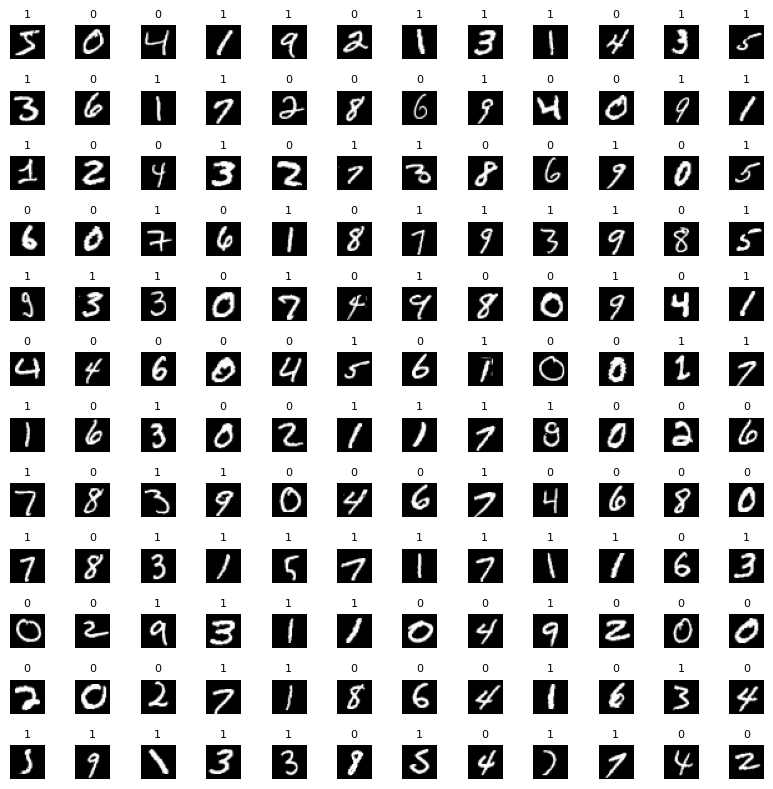

In [6]:
plt.figure(figsize=(8, 8))

for i in range(144):
    img, label = mnist_trainset[i]
    plt.subplot(12, 12, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(str(label), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
train_loader = data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

In [8]:
learning_rate = 1e-3
n_epochs = 5

encoder = MLPEncoder(in_dim=28*28*1, latent_dim=16, output_neurons=()).to(device)
#encoder = ConvEncoder(in_channels=1)
classifier = Classifier(latent_dim=16).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

In [9]:
# training loop
for epoch in range(n_epochs):
    encoder.train()
    classifier.train()
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        z = encoder(images)
        outputs = classifier(z)
        loss = criterion(outputs, labels.long())
        
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} complete: Loss = {loss.item():.6f}")

Epoch 1 complete: Loss = 0.244921
Epoch 2 complete: Loss = 0.260331
Epoch 3 complete: Loss = 0.279073
Epoch 4 complete: Loss = 0.235233
Epoch 5 complete: Loss = 0.315283


In [ ]:
all_preds = []
all_labels = []

encoder.eval()
classifier.eval()

with torch.no_grad():
    for images, labels in test_loader:
        z = encoder(images)
        outputs = classifier(z)
        preds = torch.softmax(outputs, dim=1)[:, 1] > 0.5
        preds = preds.long().flatten()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds, target_names=["Even","Odd"]))

              precision    recall  f1-score   support

        Even       0.91      0.88      0.90      4926
         Odd       0.89      0.92      0.90      5074

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [11]:
# MLP
print(classification_report(all_labels, all_preds, target_names=["Even", "Odd"]))

              precision    recall  f1-score   support

        Even       0.91      0.88      0.90      4926
         Odd       0.89      0.92      0.90      5074

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [12]:
# convolutional
print(classification_report(all_labels, all_preds, target_names=["Even", "Odd"]))

              precision    recall  f1-score   support

        Even       0.91      0.88      0.90      4926
         Odd       0.89      0.92      0.90      5074

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
p_y_a = [
    [0.9 if i == j else 0.1/9 for i in range(10)]
    for j in range(10)
]
data_dir = os.path.join(project_root, "data/cifar_data")
train_set = BiasedCifar10(root=data_dir, p_y_a=p_y_a, train=True,  download=True, seed=42)
test_set = BiasedCifar10(root=data_dir, p_y_a=p_y_a, train=False, download=True, seed=42)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4)
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=4)

encoder = ConvEncoderCIFAR(latent_dim=64, image_dim=32, in_channels=3).to(device)
classifier = Classifier(latent_dim=64, C=10).to(device)

optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 6):
    encoder.train(); classifier.train()
    for imgs, _, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        z = encoder(imgs)
        loss = criterion(classifier(z), labels)
        loss.backward()
        optimizer.step()
    print(f"[CIFAR] Epoch {epoch} loss: {loss.item():.4f}")


encoder.eval()
classifier.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, _, labels in test_loader:
        imgs = imgs.to(device)
        logits = classifier(encoder(imgs))
        preds = logits.argmax(dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\nBiased CIFAR-10 Results:")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

[CIFAR] Epoch 1 loss: 0.3623
[CIFAR] Epoch 2 loss: 0.2756
[CIFAR] Epoch 3 loss: 0.2481
[CIFAR] Epoch 4 loss: 0.3365
[CIFAR] Epoch 5 loss: 0.1677

Biased CIFAR-10 Results:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1000
           1       0.91      0.94      0.93      1000
           2       0.91      0.88      0.90      1000
           3       0.92      0.89      0.90      1000
           4       0.91      0.91      0.91      1000
           5       0.90      0.90      0.90      1000
           6       0.94      0.90      0.92      1000
           7       0.93      0.90      0.92      1000
           8       0.86      0.94      0.90      1000
           9       0.92      0.91      0.92      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



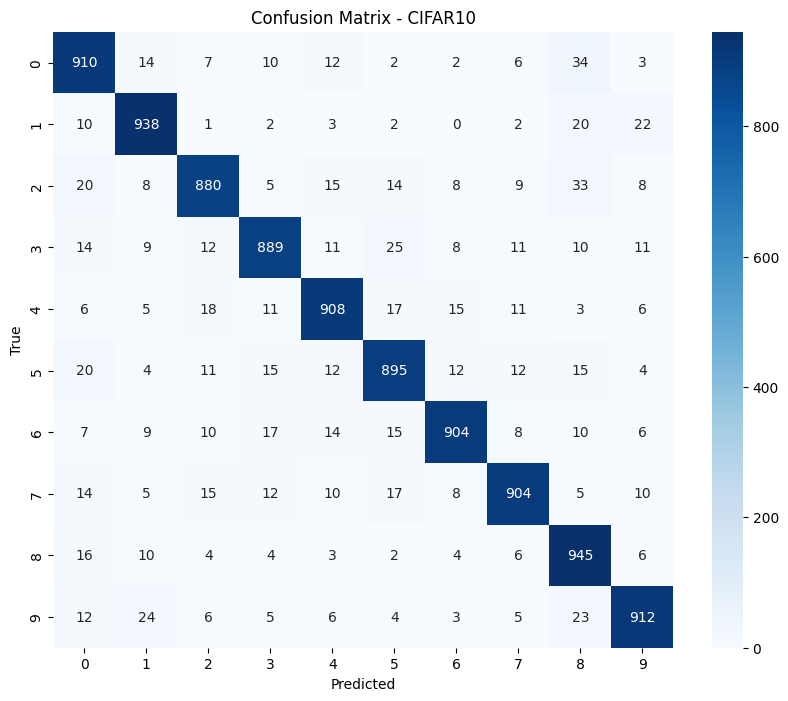

In [ ]:
# Confusion matrix for biased CIFAR10
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR10")
plt.show()